In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import plotly.express as px



# Cargar el dataset desde el archivo CSV
df = pd.read_csv("IMDB Dataset SPANISH_2000.csv")
df = df[['review_es', 'sentimiento']]




In [27]:
total_positive = df.sentimiento[df.sentimiento == 'positivo'].shape[0]
print('Count Positive Review: '+str(total_positive))
total_negative = df.sentimiento[df.sentimiento != 'positivo'].shape[0]
print('Count Negative Review: '+str(total_negative))

Count Positive Review: 1005
Count Negative Review: 996


In [20]:
from nltk import word_tokenize


def text_count(text):
    set_dict = set()
    #tokenizamos
    text = word_tokenize(text)
    [set_dict.add(palabra) for palabra in text]
    return len(set_dict)


df['words'] = df.review_es.map(text_count)
df

,review_es,sentimiento,words
0,Uno de los otros críticos ha mencionado que de...,positivo,213
1,Una pequeña pequeña producción.La técnica de f...,positivo,118
2,Pensé que esta era una manera maravillosa de p...,positivo,126
3,"Básicamente, hay una familia donde un niño peq...",negativo,93
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo,151
...,...,...,...
1996,"THE CELL (2000) Rating: 8/10The Cell, like Ant...",positivo,137
1997,"Esta película, a pesar de su lista de Celebs d...",negativo,110
1998,Me encantó esta película!Fue todo lo que podía...,positivo,65
1999,Esta fue la peor película que he visto en Bill...,negativo,98


In [23]:
fig = px.histogram(df, x = 'words', color = 'sentimiento', title = 'Histogram Count Words per Review')
fig.show()

In [ ]:
# Tokenizar los textos utilizando BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_length = 192  # Longitud máxima de secuencia para BERT
batch_size = 32


def tokenize_text(text):
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

encoded_texts = df['review_es'].apply(tokenize_text)
labels = df['sentimiento'].map({'positivo': 1, 'negativo': 0})


In [2]:


# Dividir el dataset en conjuntos de entrenamiento, validación y prueba
train_texts, val_test_texts, train_labels, val_test_labels = train_test_split(encoded_texts, labels, test_size=0.25, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_test_texts, val_test_labels, test_size=0.55, random_state=42)

# Convertir los datos divididos a tensores de PyTorch
train_texts_tensor = torch.cat([text['input_ids'] for text in train_texts])
train_masks_tensor = torch.cat([text['attention_mask'] for text in train_texts])
train_labels_tensor = torch.tensor(train_labels.values)

val_texts_tensor = torch.cat([text['input_ids'] for text in val_texts])
val_masks_tensor = torch.cat([text['attention_mask'] for text in val_texts])
val_labels_tensor = torch.tensor(val_labels.values)

test_texts_tensor = torch.cat([text['input_ids'] for text in test_texts])
test_masks_tensor = torch.cat([text['attention_mask'] for text in test_texts])
test_labels_tensor = torch.tensor(test_labels.values)

# Construir los conjuntos de datos para DataLoader
train_dataset = TensorDataset(train_texts_tensor, train_masks_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_texts_tensor, val_masks_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_texts_tensor, test_masks_tensor, test_labels_tensor)

# Construir los DataLoader para el conjunto de entrenamiento, validación y prueba
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
len(train_loader)

47

                      [input_ids, attention_mask]
                                |
                                |
                                v
                           [BertModel]
                                |
                                |
                                v
                           [dropout]
                                |
                                |
                                v
                             [conv1d]
                                |
                                |
                                v
                              [ReLU]
                                |
                                |
                                v
                          [max_pool1d]
                                |
                                |
                                v
                             [fc]
                                |
                                |
                                v
                           [logits]


- [input_ids, attention_mask]: Entrada del modelo, que consiste en los IDs de entrada y las máscaras de atención.
- [BertModel]: La capa de modelo BERT pre-entrenada.
- [dropout]: Capa de dropout para regularización.
- [conv1d]: Capa de convolución unidimensional.
- [ReLU]: Función de activación ReLU.
- [max_pool1d]: Capa de pooling unidimensional para reducir la dimensionalidad.
- [fc]: Capa completamente conectada (fully connected) para la clasificación.
- [logits]: Salida del modelo, que son los logits que representan las predicciones de clase.

In [4]:


class SentimentClassifier(nn.Module):
    def __init__(self, dropout, l2_lambda=0.0001):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.fc = nn.Linear(256, 2)
        self.l2_lambda = l2_lambda  # Factor de regularización L2

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        conv_output = self.conv1(pooled_output.unsqueeze(2))  # Añadir una dimensión adicional
        conv_output = F.relu(conv_output)
        pooled_output = F.max_pool1d(conv_output, kernel_size=conv_output.shape[2])
        pooled_output = pooled_output.squeeze(2)
        logits = self.fc(pooled_output)

        return logits


In [5]:
def train(model, train_iterator, val_iterator, test_iterator, optimizer, criterion, device, num_epochs):
    train_losses = []
    val_losses = []
    test_losses = []
    train_accs = []
    val_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        
        # Entrenamiento
        train_loss, train_acc = _train_epoch(model, train_iterator, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        
        # Validación
        val_loss, val_acc = _evaluate(model, val_iterator, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        # Test
        test_loss, test_acc = _evaluate(model, test_iterator, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')
        print('-' * 50)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accs': test_accs
    }

def _train_epoch(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    i = 0
    for input_ids, attention_mask, labels in iterator:
        print('--- Iterator: '+str(i))
        i = i+1
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(input_ids, attention_mask)
        loss = criterion(predictions, labels)
        
        # Regularización L2
        l2_reg = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_reg += torch.norm(param)**2
        loss += model.l2_lambda * l2_reg
        
        acc = accuracy_score(torch.argmax(predictions, axis=1).cpu().numpy(), labels.cpu().numpy())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def _evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        i = 0
        for input_ids, attention_mask, labels in iterator:
            print('--- Iterator: '+str(i))
            i = i+1
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            predictions = model(input_ids, attention_mask)
            loss = criterion(predictions, labels)
            
            # No se aplica la regularización L2 durante la evaluación
            acc = accuracy_score(torch.argmax(predictions, axis=1).cpu().numpy(), labels.cpu().numpy())
            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [6]:
# Definir hiperparámetros
NUM_EPOCHS = 10
LEARNING_RATE = 3e-5

# Inicializar modelo, optimizador y función de pérdida
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(dropout=0.4, l2_lambda=0.00001).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=model.l2_lambda)  # Ajustar weight_decay con el factor de regularización L2
criterion = nn.CrossEntropyLoss().to(device)

# Entrenar el modelo
resultados_entrenamiento = train(model, train_loader, val_loader, test_loader, optimizer, criterion, device, NUM_EPOCHS)

Epoch 1/10
--- Iterator: 0
--- Iterator: 1
--- Iterator: 2
--- Iterator: 3
--- Iterator: 4
--- Iterator: 5
--- Iterator: 6
--- Iterator: 7
--- Iterator: 8
--- Iterator: 9
--- Iterator: 10
--- Iterator: 11
--- Iterator: 12
--- Iterator: 13
--- Iterator: 14
--- Iterator: 15
--- Iterator: 16
--- Iterator: 17
--- Iterator: 18
--- Iterator: 19
--- Iterator: 20
--- Iterator: 21
--- Iterator: 22
--- Iterator: 23
--- Iterator: 24
--- Iterator: 25
--- Iterator: 26
--- Iterator: 27
--- Iterator: 28
--- Iterator: 29
--- Iterator: 30
--- Iterator: 31
--- Iterator: 32
--- Iterator: 33
--- Iterator: 34
--- Iterator: 35
--- Iterator: 36
--- Iterator: 37
--- Iterator: 38
--- Iterator: 39
--- Iterator: 40
--- Iterator: 41
--- Iterator: 42
--- Iterator: 43
--- Iterator: 44
--- Iterator: 45
--- Iterator: 46
Train Loss: 2.7219 | Train Acc: 0.4871
--- Iterator: 0
--- Iterator: 1
--- Iterator: 2
--- Iterator: 3
--- Iterator: 4
--- Iterator: 5
--- Iterator: 6
--- Iterator: 7
Val Loss: 0.6920 | Val Acc: 0.597

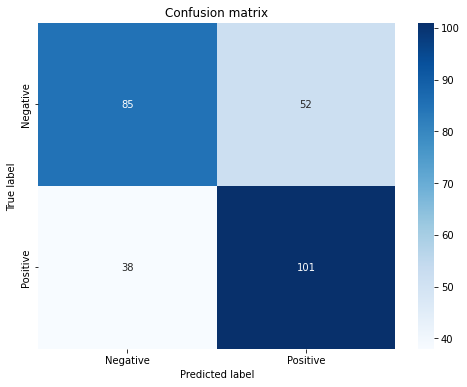

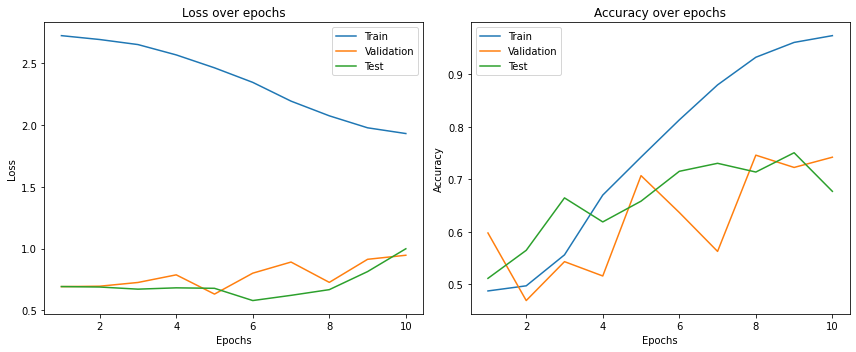

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

def plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, val_losses, label='Validation')
    plt.plot(epochs, test_losses, label='Test')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train')
    plt.plot(epochs, val_accs, label='Validation')
    plt.plot(epochs, test_accs, label='Test')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Obtener las predicciones para el conjunto de prueba
def get_predictions(model, iterator):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in iterator:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            output = model(input_ids, attention_mask)
            predictions.extend(torch.argmax(output, axis=1).tolist())
            actuals.extend(labels.tolist())

    return predictions, actuals

# Obtener las predicciones y los valores reales
test_predictions, test_actuals = get_predictions(model, test_loader)

# Obtener las clases
classes = ['Negative', 'Positive']

# Plotear la matriz de confusión
plot_confusion_matrix(test_actuals, test_predictions, classes)

# Plotear las métricas
plot_metrics(
    resultados_entrenamiento['train_losses'],
    resultados_entrenamiento['val_losses'],
    resultados_entrenamiento['test_losses'],
    resultados_entrenamiento['train_accs'],
    resultados_entrenamiento['val_accs'],
    resultados_entrenamiento['test_accs']
)


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcular precisión, recall y F-score
precision = precision_score(test_actuals, test_predictions, average='weighted')
recall = recall_score(test_actuals, test_predictions, average='weighted')
f1 = f1_score(test_actuals, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F-score: {f1:.4f}')


Precision: 0.6755
Recall: 0.6739
F-score: 0.6730
